In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Final2022/bionet')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchsummary import summary
import numpy as np
import math
import os
import psutil
print(torch.__version__)
print(torch.cuda.get_device_name(0))

1.12.0+cu113
Tesla V100-SXM2-16GB


In [5]:

transform = transforms.Compose([
#     transforms.CenterCrop(224),
  
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 
Batch_Size = 256
trainset = datasets.CIFAR10(root='../../data/', train=True,download=False, transform=transform)
testset = datasets.CIFAR10(root='../../data/',train=False,download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
Batch_Size = 256
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

'''cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}'''

class GaborConv2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        self.is_calculated = False

        self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        self.kernel_size = self.conv_layer.kernel_size

        # small addition to avoid division by zero
        self.delta = 1e-3

        # freq, theta, sigma are set up according to S. Meshgini,
        # A. Aghagolzadeh and H. Seyedarabi, "Face recognition using
        # Gabor filter bank, kernel principal component analysis
        # and support vector machine"
        self.freq = nn.Parameter((math.pi / 2) * math.sqrt(2) ** (-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor),requires_grad=True, )
        self.theta = nn.Parameter((math.pi / 8) * torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor),requires_grad=True,)
        self.sigma = nn.Parameter(math.pi / self.freq, requires_grad=True)
        self.psi = nn.Parameter(math.pi * torch.rand(out_channels, in_channels), requires_grad=True)
        self.x0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[0] / 2]))[0], requires_grad=False)
        self.y0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[1] / 2]))[0], requires_grad=False)
        self.y, self.x = torch.meshgrid(
            [torch.linspace(-self.x0 + 1, self.x0 + 0, self.kernel_size[0]),
             torch.linspace(-self.y0 + 1, self.y0 + 0, self.kernel_size[1]),])
        self.y = nn.Parameter(self.y)
        self.x = nn.Parameter(self.x)
        self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=True),requires_grad=True,)


        self.register_parameter("freq", self.freq)
        self.register_parameter("theta", self.theta)
        self.register_parameter("sigma", self.sigma)
        self.register_parameter("psi", self.psi)
        self.register_parameter("x_shape", self.x0)
        self.register_parameter("y_shape", self.y0)
        self.register_parameter("y_grid", self.y)
        self.register_parameter("x_grid", self.x)
        self.register_parameter("weight", self.weight)

    def forward(self, input_tensor):
        if self.training:
            self.calculate_weights()
            #print(self.conv_layer.weight.data.shape)
            self.is_calculated = False
        if not self.training:
            if not self.is_calculated:
                self.calculate_weights()
                self.is_calculated = True
        return self.conv_layer(input_tensor)

    def calculate_weights(self):
        for i in range(self.conv_layer.out_channels):
            for j in range(self.conv_layer.in_channels):
                sigma = self.sigma[i, j].expand_as(self.y)
                freq = self.freq[i, j].expand_as(self.y)
                theta = self.theta[i, j].expand_as(self.y)
                psi = self.psi[i, j].expand_as(self.y)

                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta)

                g = torch.exp(-0.5 * ((rotx ** 2 + roty ** 2) / (sigma + self.delta) ** 2))
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2 * math.pi * sigma ** 2)
                self.conv_layer.weight.data[i, j] = g

class GaborConvFixed(nn.Module):
    def __init__(self,
          in_channels,
          out_channels,
          input_dict,
          kernel_size,
          stride=1,
          padding=0,
          dilation=1,
          groups=1,
          bias=False,
          padding_mode="zeros",
          ):
      super().__init__()
      self.input_dict=input_dict
      if self.input_dict==None:
          self.input_dict = {  # 'ksize': (127, 127),
            'ksize': (31, 31),
            'gammas': [0.5],
            #           'bs': np.linspace(0.4, 2.6, num=3),  # 0.4, 1, 1.8, 2.6
            #           'bs': np.linspace(0.4, 2.6, num=5),
            'bs': np.linspace(1, 2.6, num=3).tolist(),
            #           'bs': np.linspace(1, 2.6, num=5),
            #           'sigmas': [4, 8, 16],  # , 32
            'sigmas': [8],
            'thetas': np.linspace(0, np.pi, 4, endpoint=False).tolist(),
            'psis': [np.pi / 2, 3 * np.pi / 2]}
      
      self.ksize = self.input_dict["ksize"]
      self.sigmas = self.input_dict["sigmas"]
      self.bs = self.input_dict["bs"]
      self.gammas = self.input_dict["gammas"]
      self.thetas = self.input_dict["thetas"]
      self.psis = self.input_dict["psis"]

      self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
      
      self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=False),requires_grad=False,)

    def calc_lambda(self, sigma, bandwidth):
      p = 2**bandwidth
      c = np.sqrt(np.log(2)/2)
      return sigma * np.pi / c  * (p - 1) / (p + 1)
    
    def forward(self, input_tensor):
      self.calculate_weights()
      return self.conv_layer(input_tensor)
    
    def calculate_weights(self):
      for i in range(self.conv_layer.out_channels):
          for j in range(self.conv_layer.in_channels):
              for sigma in self.sigmas:
                for theta in self.thetas:
                    # for lambd in lambdas:
                    for b in self.bs:
                        lambd = self.calc_lambda(sigma, b)
                        for gamma in self.gammas:
                            for psi in self.psis:
                                gf = cv2.getGaborKernel(self.ksize, sigma, theta,lambd, gamma, psi, ktype=cv2.CV_64F)
                                self.conv_layer.weight.data[i, j] = torch.tensor(gf)

class VGG(nn.Module):
    
    def __init__(self, vgg_name, param=None):
        super(VGG, self).__init__()
        self.param=param
        self.Gabor_out_channels=64
        '''if param:
          self.g0=GaborConvFixed(in_channels=3, out_channels= 24, input_dict=self.param,kernel_size=(31, 31) ,padding=15)
        else:'''
        self.g0=GaborConv2d(in_channels=5, out_channels= self.Gabor_out_channels, kernel_size=(31, 31),padding=15)
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )
#         self.classifier = nn.Linear(512,10)

        self._initialize_weight()
        
    def forward(self, x):
      x=self.opponency_encoder(x)
      out = self.features(self.g0(x))
      # 在进入
      out = out.view(out.size(0), -1)
      #out = self.classifier(out)
      return out
    def opponency_encoder(self,data_tensor):
      num, channel, row, col=data_tensor.shape
      inputshape=(num,int(channel/3),row,col)
      r = data_tensor[:, 0, :, :]
      g = data_tensor[:, 1, :, :]
      b = data_tensor[:, 2, :, :]
      I = ((r + g + b) / 3).reshape(inputshape)
      R = torch.clamp(r - (g + b) / 2,min=0.0)
      G = torch.clamp(g - (r - b) / 2,min=0.0)
      B = torch.clamp(b - (r + g) / 2,min=0.0)
      Y = torch.clamp((r + g) / 2 - (r - g) / 2 - b,min=0.0)
      RG = torch.clamp(R - G,min=0.0).reshape(inputshape)
      GR = torch.clamp(G - R,min=0.0).reshape(inputshape)
      BY = torch.clamp(B - Y,min=0.0).reshape(inputshape)
      YB = torch.clamp(Y - B,min=0.0).reshape(inputshape)
      return torch.cat((I,RG,GR,BY,YB),1)
    # make layers

    def _make_layers(self, cfg):
        layers = []
        in_channels = self.Gabor_out_channels # RGB 初始通道为3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size 为 2 x 2,然后步长为2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # 都是(3.3)的卷积核
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]  # RelU
                in_channels = x  # 重定义通道
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    # 初始化参数
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
input_dict = {  # 'ksize': (127, 127),
            'ksize': (31, 31),
            'gammas': [0.5],
            #           'bs': np.linspace(0.4, 2.6, num=3),  # 0.4, 1, 1.8, 2.6
            #           'bs': np.linspace(0.4, 2.6, num=5),
            'bs': np.linspace(1, 2.6, num=3).tolist(),
            #           'bs': np.linspace(1, 2.6, num=5),
            #           'sigmas': [4, 8, 16],  # , 32
            'sigmas': [8],
            'thetas': np.linspace(0, np.pi, 4, endpoint=False).tolist(),
            'psis': [np.pi / 2, 3 * np.pi / 2]}
      
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = VGG('VGG16').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) # 得到概率
    correct = (pred_y == label).sum().data
    return correct / total


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

def train(net, trainloader, testloader, epoches, optimizer , criterion, scheduler , path = './model.pth', writer = None ,verbose = False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            # 释放内存
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            # 更新参数
            optimizer.step()

            train_loss += loss.data
            # probs, pred_y = outputs.data.max(dim=1) # 得到概率
            # # 正确的个数
            # train_acc += (pred_y==label).sum().item()
            # # 总数
            # total += label.size(0)
            train_acc += get_acc(outputs,label)
            # 打印下载进度
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        # 记录学习率
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        # 更新学习率
        scheduler.step(train_loss)
        if testloader is not None:
            net.eval()
            with torch.no_grad():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    # 释放内存
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    # probs, pred_y = outputs.data.max(dim=1) # 得到概率
                    # test_acc += (pred_y==label).sum().item()
                    # total += label.size(0)
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        # ====================== 使用 tensorboard ==================
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': test_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': test_acc}, i+1)
            writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        # 打印所用时间
        print(time_str)
        # 如果取得更好的准确率，就保存模型
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr
import matplotlib.pyplot as plt
def plot_history(epoches, Acc, Loss, lr):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

In [8]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 1e-100) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 200
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/OpponencyCifarGaborVGG16.pth'
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

文件已存在


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [  1/200]  Train Loss:1.938111  Train Acc:33.00% Test Loss:1.486664  Test Acc:46.51%  Learning Rate:0.100000	Time 00:57
Epoch [  2/200]  Train Loss:1.226820  Train Acc:55.70% Test Loss:1.501663  Test Acc:46.89%  Learning Rate:0.100000	Time 00:49
Epoch [  3/200]  Train Loss:0.967558  Train Acc:65.98% Test Loss:0.969859  Test Acc:66.39%  Learning Rate:0.100000	Time 00:50
Epoch [  4/200]  Train Loss:0.829250  Train Acc:71.16% Test Loss:0.962465  Test Acc:67.23%  Learning Rate:0.100000	Time 00:49
Epoch [  5/200]  Train Loss:0.742351  Train Acc:74.49% Test Loss:0.816065  Test Acc:72.27%  Learning Rate:0.100000	Time 00:51
Epoch [  6/200]  Train Loss:0.671937  Train Acc:77.11% Test Loss:0.813355  Test Acc:72.62%  Learning Rate:0.100000	Time 00:50
Epoch [  7/200]  Train Loss:0.622941  Train Acc:78.94% Test Loss:0.796944  Test Acc:73.81%  Learning Rate:0.100000	Time 00:50
Epoch [  8/200]  Train Loss:0.585699  Train Acc:80.10% Test Loss:1.132439  Test Acc:65.32%  Learning Rate:0.100000	Tim

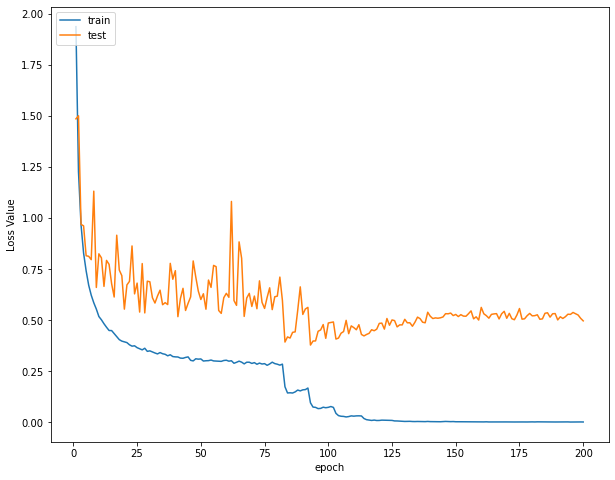

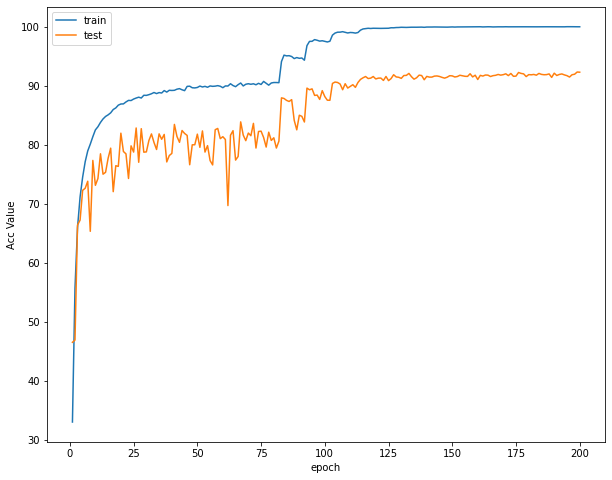

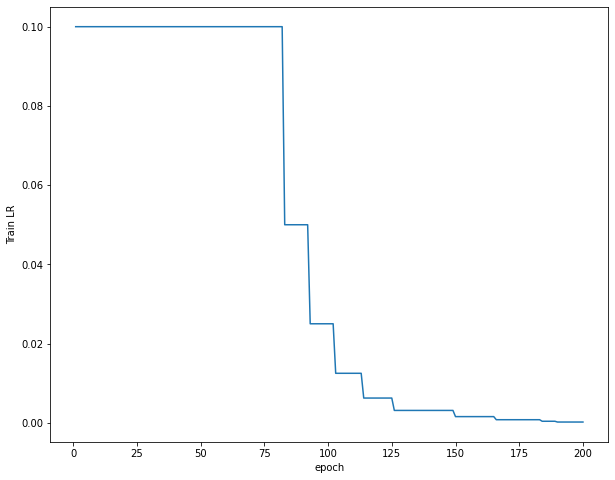

In [9]:
plot_history(epoch ,Acc, Loss, Lr)